In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

Aluno: Matheus Fillype Ferreira de Carvalho - 
Matrícula: 181708017

## Rotação

In [2]:
def myRotation(angle: float, center: tuple, img_path: str, to_save: bool = False, path_to_save: str = None):
    """
    Rotaciona uma imagem em um ângulo específico em torno de um ponto de referência.

    Parâmetros:
        angle (float): O ângulo de rotação em graus.
        center (tuple): As coordenadas (x, y) do centro de rotação.
        img_path (str): O caminho para o arquivo da imagem a ser rotacionada.
        to_save (bool, opcional): Se True, a imagem rotacionada será salva. O padrão é False.
        path_to_save (str, opcional): O caminho onde a imagem rotacionada será salva. 
            Este parâmetro é obrigatório se to_save for True.

    Retorna:
        None

    Exemplo de uso:
        myRotation(30, (100, 100), 'imagem.jpg', to_save=True, path_to_save='imagem_rotacionada.jpg')
    """

    # Carregar a imagem
    img = np.array(Image.open(img_path))

    # Obter as dimensões da imagem
    height, width = img.shape[:2]

    # Aplicar a rotação na imagem usando a matriz de rotação
    theta = np.radians(angle)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    rotation_matrix = np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])
    offset = np.dot(rotation_matrix, center - np.array([width / 2, height / 2])) + np.array([width / 2, height / 2])
    rotated_img = np.zeros_like(img)

    for y in range(height):
        for x in range(width):
            new_x, new_y = np.dot(rotation_matrix, [x, y]) + offset
            if 0 <= new_x < width and 0 <= new_y < height:
                rotated_img[int(new_y), int(new_x)] = img[y, x]

    # Exibir a imagem rotacionada
    plt.imshow(rotated_img.astype(np.uint8))
    plt.axis('off')
    plt.show()

    # Salvar a imagem rotacionada, se necessário
    if to_save:
        if path_to_save is None:
            raise ValueError("Se 'to_save' é True, 'path_to_save' deve ser fornecido.")
        Image.fromarray(rotated_img.astype(np.uint8)).save(path_to_save)


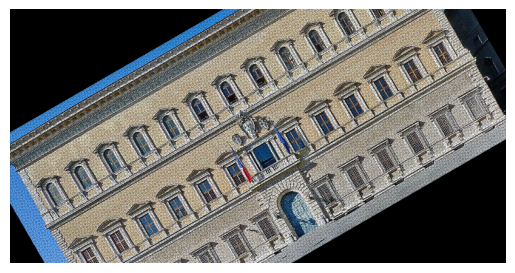

In [3]:
myRotation(-30, (0,0), "Palazzo_Farnese_Fassade.jpg")

## Transformação Projetiva

In [4]:
def my_transform(img_path: str, T, to_show:bool=True, to_save: bool = False, path_to_save: str = None):
    """
    Aplica uma transformação projetiva (homografia) em uma imagem.

    Parâmetros:
        img_path (str): O caminho para o arquivo da imagem de entrada.
        T: Matriz de transformação projetiva.
        to_save (bool, opcional): Se True, a imagem transformada será salva. O padrão é False.
        path_to_save (str, opcional): O caminho onde a imagem transformada será salva.
            Este parâmetro é obrigatório se to_save for True.

    Retorna:
        transform_image: Imagem transformada.
    """
    # Carregar a imagem como uma matriz
    img = np.array(Image.open(img_path))

    # Obter as dimensões da imagem
    height, width = img.shape[:2]

    # Criar uma matriz vazia para a imagem transformada
    transform_image = np.zeros_like(img)

    # Gerar uma grade de coordenadas para todos os pixels da imagem original
    grid_x, grid_y = np.meshgrid(np.arange(width), np.arange(height))
    coords_orig = np.stack([grid_y.flatten(), grid_x.flatten(), np.ones_like(grid_x.flatten())], axis=1)

    # Aplicar a transformação projetiva para encontrar as coordenadas transformadas
    coords_transformed = np.dot(coords_orig, T.T)

    # Converter as coordenadas transformadas de volta para a grade da imagem
    coords_transformed[:, 0] /= coords_transformed[:, 2]
    coords_transformed[:, 1] /= coords_transformed[:, 2]

    # Arredondar as coordenadas transformadas para os índices mais próximos
    coords_transformed = np.round(coords_transformed).astype(int)

    # Limitar as coordenadas transformadas aos limites da imagem transformada
    coords_transformed[:, 0] = np.clip(coords_transformed[:, 0], 0, height - 1)
    coords_transformed[:, 1] = np.clip(coords_transformed[:, 1], 0, width - 1)

    # Atribuir os valores dos pixels da imagem original na imagem transformada
    transform_image[coords_transformed[:, 0], coords_transformed[:, 1]] = img[coords_orig[:, 0], coords_orig[:, 1]]

    # Salvar a imagem transformada, se necessário
    if to_save:
        if path_to_save is None:
            raise ValueError("Se 'to_save' é True, 'path_to_save' deve ser fornecido.")
        Image.fromarray(transform_image.astype(np.uint8)).save(path_to_save)

    if to_show:
        # Exibir a imagem transformada
        plt.imshow(transform_image.astype(np.uint8))
        plt.axis('off')
        plt.show()
    else:
        return transform_image

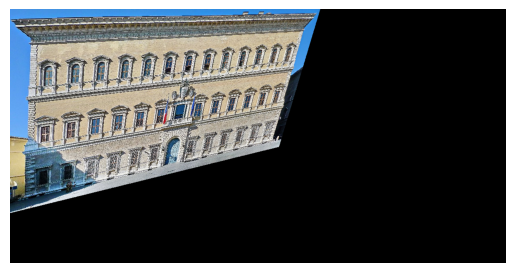

In [5]:

# Testar a função com uma matriz de transformação projetiva para um ponto de fuga no eixo x
T = np.array([[1, 0, 0],   
              [0, 1, 0],   
              [1/2500, 1/2000, 1]])  

my_transform('Palazzo_Farnese_Fassade.jpg', T)

## Estimação de Transformação Projetiva

In [6]:
def my_estimation(lst1, lst2):
    """
    Estima a transformação projetiva que mapeia os pontos "fonte" nos pontos "destino".

    Parâmetros:
        lst1: Lista de pontos "fonte" no plano projetivo. Cada ponto é uma lista [x, y].
        lst2: Lista de pontos "destino" no plano projetivo. Cada ponto é uma lista [x, y].

    Retorna:
        estimation_T: A matriz de transformação projetiva T que mapeia os pontos "fonte" nos pontos "destino".
    """
    # Inicializa as matrizes de origem e destino com zeros
    matriz_origem = np.zeros((len(lst1), 3))
    matriz_destino = np.zeros((len(lst2), 3))

    # Preenche as matrizes de origem e destino com os pontos fornecidos
    for i in range(len(lst1)):
        # Monta a matriz de origem com os pontos originais e a matriz de destino com os pontos de destino
        ponto_origem = lst1[i]
        ponto_destino = lst2[i]

        matriz_origem[i] = [ponto_origem[0], ponto_origem[1], 1]
        matriz_destino[i] = [ponto_destino[0], ponto_destino[1], 1]

    # Usa a função lstsq do numpy para estimar a matriz de transformação
    estimation_T = np.linalg.lstsq(matriz_origem, matriz_destino, rcond=None)[0]

    return estimation_T.T

In [7]:
# Esses pontos foram definidos parte por tentativa e erro e parte após um conselho do colega Sillas Rocha
ori_pts = [[210, 100], [220, 270], [350, 220], [350, 0]]
des_pts = [[210, 100], [220, 270], [350, 275], [348, 90]]

estimation_T = my_estimation(ori_pts, des_pts)
print("Transformação projetiva estimada:")
print(estimation_T)


Transformação projetiva estimada:
[[ 9.95517909e-01  5.72396626e-03 -7.80943161e-02]
 [ 4.80154889e-01  8.90817314e-01 -8.32893099e+01]
 [-2.95478176e-18  2.60208521e-18  1.00000000e+00]]


### Teste (Estimação Transformação Projetiva)

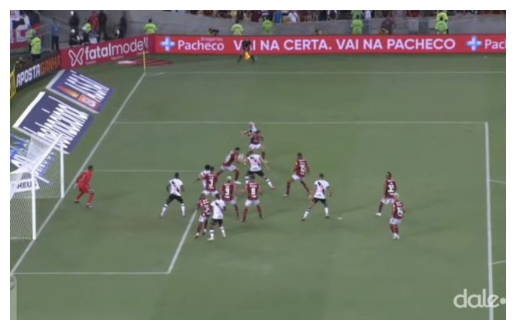

In [8]:
img = np.array(Image.open("Vasco_Flamengo.jpg"))
plt.imshow(img)
plt.axis('off')
plt.show()

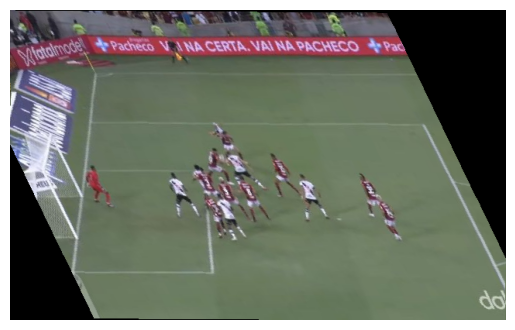

In [9]:
my_transform('Vasco_Flamengo.jpg', estimation_T)

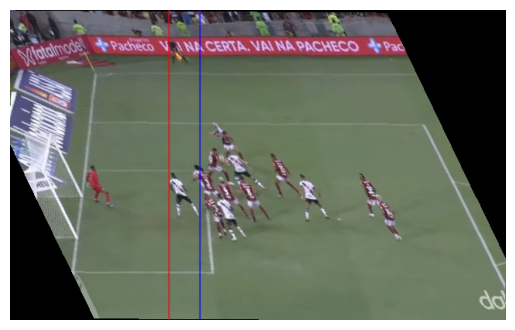

In [10]:
img = my_transform('Vasco_Flamengo.jpg', estimation_T, to_show=False)
plt.axvline(x=245, color='blue', linestyle='-', alpha=0.5)
plt.axvline(x=205, color='red', linestyle='-', alpha=0.5)
plt.imshow(img)
plt.axis('off')
plt.show()